# GSOM VK project
## Read files from S3 with Spark

### 1. Libraries

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from datetime import datetime, timedelta
from pyspark.sql import udf
from pyspark.sql.types import *
from pyspark.sql.functions import struct
from pyspark.sql.functions import countDistinct
import multiprocessing
pd.set_option('display.max_columns', None)
N_CORES = min(
    multiprocessing.cpu_count(), 
    int(float(os.environ['CPU_LIMIT']))
)
print('max cores available:', N_CORES)

max cores available: 5


### 2. Credentials and Spark settings

In [2]:
BUCKET = 'rawdata-test-vk'
with open('access_vk.json') as file:
    access_data = json.load(file)

In [3]:
print('user:', os.environ['JUPYTERHUB_SERVICE_PREFIX'])

def uiWebUrl(self):
    from urllib.parse import urlparse
    web_url = self._jsc.sc().uiWebUrl().get()
    port = urlparse(web_url).port
    return '{}proxy/{}/jobs/'.format(os.environ['JUPYTERHUB_SERVICE_PREFIX'], port)

SparkContext.uiWebUrl = property(uiWebUrl)

conf = SparkConf()

conf.set('spark.master', 'local[*]')
conf.set('spark.driver.memory', '16G')
conf.set('spark.driver.maxResultSize', '4G')
sc = SparkContext(conf=conf)
spark = SparkSession(sc)
spark

user: /user/st055102/


23/06/01 17:22:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:
spark._jsc.hadoopConfiguration().set('fs.s3a.access.key', access_data['aws_access_key_id'])
spark._jsc.hadoopConfiguration().set('fs.s3a.secret.key', access_data['aws_secret_access_key'])
spark._jsc.hadoopConfiguration().set('fs.s3a.impl','org.apache.hadoop.fs.s3a.S3AFileSystem')
spark._jsc.hadoopConfiguration().set('fs.s3a.multipart.size', '104857600')
spark._jsc.hadoopConfiguration().set('fs.s3a.block.size', '33554432')
spark._jsc.hadoopConfiguration().set('fs.s3a.threads.max', '256')
spark._jsc.hadoopConfiguration().set('fs.s3a.endpoint', 'http://storage.yandexcloud.net')
spark._jsc.hadoopConfiguration().set('fs.s3a.aws.credentials.provider', 'org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider')

### 3. Structure of the data

There are three groups in the bucket:
- gsom_abiturient
- gsom_ma
- gsom.spbu

Data is updated every week, last available data is (names of the folders):
- gsom_abiturient-2022-12-20-05-00-20-364747 (–≤—Ç–æ—Ä–Ω–∏–∫)
- gsom_ma-2022-12-19-05-00-08-338606 (–ø–æ–Ω–µ–¥–µ–ª—å–Ω–∏–∫)
- gsom_spbu-2022-12-14-05-00-08-207227 (—Å—Ä–µ–¥–∞)

Structure in every folder is as follows:
- `/walls` folder with walls data of members oh the group
- `<GROUP_NAME>.json` (e.g.`gsom_abiturient.json`) file with the group description
- `members_full_group_<GROUP_NAME>.json` (e.g. `members_full_group_gsom_abiturient.json`) file with the full data for members of the group
- `members_group_<GROUP_NAME>.json` (e.g. `members_group_gsom_abiturient.json`) file with the list of group's members
- `wall_owner_id_<GROUP_ID>.json` (e.g. `wall_owner_id_23777199.json`) file with wall of the group

In [5]:
all_groups = [
    'gsom_abiturient',
    'gsom_ma',
    'gsom.spbu'
]

### 4. Read data examples

#### 4.1.Group info

In [6]:
file_path = f's3a://{BUCKET}/gsom_abiturient-2022-12-20*/gsom_abiturient.json'
print('file path to load:', file_path)
sdf = spark.read.json(file_path)

file path to load: s3a://rawdata-test-vk/gsom_abiturient-2022-12-20*/gsom_abiturient.json


23/06/01 17:22:22 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


In [7]:
sdf.printSchema()

root
 |-- activity: string (nullable = true)
 |-- addresses: struct (nullable = true)
 |    |-- count: long (nullable = true)
 |    |-- is_enabled: boolean (nullable = true)
 |    |-- main_address: struct (nullable = true)
 |    |    |-- address: string (nullable = true)
 |    |    |-- city: struct (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- title: string (nullable = true)
 |    |    |-- country: struct (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- title: string (nullable = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- title: string (nullable = true)
 |    |    |-- work_info_status: string (nullable = true)
 |    |-- main_address_id: long (nullable = true)
 |-- age_limits: long (nullable = true)
 |-- city: struct (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- title: string (nullable = true)
 |-- contacts: array (nullable = true)
 |    |-- element: struct (containsNull = tr

In [8]:
sdf.limit(5).toPandas()

23/06/01 17:22:27 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


activity                                          addresses  age_limits  \
0  Open group  (1, True, (–°–∞–Ω–∫—Ç-–ü–µ—Ç–µ—Ä–±—É—Ä–≥—Å–∫–æ–µ —à–æ—Å—Å–µ 109, (2, ...           1   

                   city                                           contacts  \
0  (2, –°–∞–Ω–∫—Ç-–ü–µ—Ç–µ—Ä–±—É—Ä–≥)  [(–î–∏—Ä–µ–∫—Ç–æ—Ä –ø—Ä–æ–≥—Ä–∞–º–º –±–∞–∫–∞–ª–∞–≤—Ä–∏–∞—Ç–∞ –í–®–ú –°–ü–±–ì–£, v....   

  counters      country                                              cover  \
0       []  (1, –†–æ—Å—Å–∏—è)  (1, [(67, https://sun1-85.userapi.com/impf/wkg...   

                                          crop_photo  \
0  ((0.0, 100.0, 0.0, 100.0), (-6, 1653384382, Fa...   

                                         description  has_photo        id  \
0  –í—Å–µ, —á—Ç–æ –Ω–µ–æ–±—Ö–æ–¥–∏–º–æ –∑–Ω–∞—Ç—å –∞–±–∏—Ç—É—Ä–∏–µ–Ω—Ç—É –í–®–ú –°–ü–±–ì...          1  23777199   

   is_closed                                              links  \
0          0  [(–û—Ñ–∏—Ü–∏–∞–ª—å–Ω–∞—è –≥—Ä—É–ø–ø–∞ —Å–æ–æ–±—â–µ—Å—Ç–≤–∞ –±–∏–∑–Ω–µ—Å-—à–∫–æ–ª—ã ‚Ññ...   

   main_album_id  main_section  market  members_count  \
0      127539091             4  (0, 0)           3307   

                                          name  \
0  –•–æ—á—É —É—á–∏—Ç—å—Å—è –≤ –í–®–ú –°–ü–±–ì–£ | –ê–±–∏—Ç—É—Ä–∏–µ–Ω—Ç—É 2023   

                                           photo_100  \
0  https://sun1-15.userapi.com/s/v1/ig2/TGZ9ny0RG...   

                                           photo_200  \
0  https://sun1-15.userapi.com/s/v1/ig2/iWwUYZ04z...   

                                            photo_50      screen_name  \
0  https://sun1-15.userapi.com/s/v1/ig2/02taGqsGO...  gsom_abiturient   

               site                                             status  \
0  www.gsom.spbu.ru  –ì—Ä—É–ø–ø–∞ –∞–±–∏—Ç—É—Ä–∏–µ–Ω—Ç–æ–≤ –±–∞–∫–∞–ª–∞–≤—Ä–∏–∞—Ç–∞ –í—ã—Å—à–µ–π —à–∫–æ–ª—ã ...   

   trending   type  verified  wall                   wiki_page  
0         0  group         0     2  –ö–∞–∫ –ø–æ—Å—Ç—É–ø–∏—Ç—å –≤ 2023 –≥–æ–¥—É?

In [9]:
sdf.count()

1

#### 4.2. Members of the group

##### List of members

In [10]:
file_path = f's3a://{BUCKET}/gsom_abiturient-*/members_group_gsom_abiturient.json'
print('file path to load:', file_path)
sdf = spark.read.json(file_path)

file path to load: s3a://rawdata-test-vk/gsom_abiturient-*/members_group_gsom_abiturient.json


In [11]:
sdf.printSchema()

root
 |-- count: long (nullable = true)
 |-- items: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- next_from: string (nullable = true)



In [12]:
sdf.limit(10).toPandas()

count                                              items  \
0   3434  [959, 1361, 1642, 9088, 10615, 11738, 18619, 3...   
1   3434  [959, 1361, 1642, 9088, 10615, 11738, 18619, 3...   
2   3433  [959, 1361, 1642, 9088, 10615, 11738, 18619, 3...   
3   3431  [959, 1361, 1642, 9088, 10615, 11738, 18619, 3...   
4   3431  [959, 1361, 1642, 9088, 10615, 11738, 18619, 3...   
5   3431  [959, 1361, 1642, 9088, 10615, 11738, 18619, 3...   
6   3424  [959, 1361, 1642, 9088, 10615, 11738, 18619, 3...   
7   3422  [959, 1361, 1642, 9088, 10615, 11738, 18619, 3...   
8   3418  [959, 1361, 1642, 9088, 10615, 11738, 18619, 3...   
9   3408  [959, 1361, 1642, 9088, 10615, 11738, 18619, 3...   

             next_from  
0  PUkGEFNHDhJkUVhGBUk  
1  PUkGEFNHDhJkUVhGBUk  
2  PUkGEFNHDhJkUVhGBUk  
3  PUkGEFNHDhJkUVhGBUk  
4  PUkGEFNHDhJkUVhGBUk  
5  PUkGEFNHDhJkUVhGBUk  
6  PUkGEFNHDhJkUVhGBUk  
7  PUkGEFNHDhJkUVhGBUk  
8  PUkGEFNHDhJkUVhGBUk  
9  PUkGEFNHDhJkUVhGBUk

In [13]:
#sdf['items_set'] = sdf['items'].apply(lambda x: set(x.str.split(', ')))
#sdf['items_set'] = sdf['items'].map(lambda x: set(x.split(', ')))
#sdf['items_set'] = sdf['items'].apply(lambda x: set(item for s in x for item in s.split(', ')))
sdf

DataFrame[count: bigint, items: array<bigint>, next_from: string]

In [14]:
sdf1 = sdf.select(
    F.explode(sdf.items)
)
sdf1.printSchema()

root
 |-- col: long (nullable = true)



In [15]:
%%time
sdf1.count()

CPU times: user 59 ¬µs, sys: 997 ¬µs, total: 1.06 ms
Wall time: 560 ms


120312

In [16]:
sdf1.limit(10).toPandas()

col
0    959
1   1361
2   1642
3   9088
4  10615
5  11738
6  18619
7  31053
8  37325
9  38445

## Detailed members info - –¥–ª—è –∫–ª–∞—Å—Ç–µ—Ä–∏–Ω–≥–∞

In [17]:
file_path = f's3a://{BUCKET}/gsom_abiturient-2023-05-23*/members_full_group_gsom_abiturient.json'
print('file path to load:', file_path)
sdf = spark.read.json(file_path)

file path to load: s3a://rawdata-test-vk/gsom_abiturient-2023-05-23*/members_full_group_gsom_abiturient.json


In [18]:
sdf.printSchema()

root
 |-- about: string (nullable = true)
 |-- activities: string (nullable = true)
 |-- bdate: string (nullable = true)
 |-- blacklisted: long (nullable = true)
 |-- blacklisted_by_me: long (nullable = true)
 |-- books: string (nullable = true)
 |-- can_access_closed: boolean (nullable = true)
 |-- can_post: long (nullable = true)
 |-- can_see_all_posts: long (nullable = true)
 |-- can_see_audio: long (nullable = true)
 |-- can_send_friend_request: long (nullable = true)
 |-- can_write_private_message: long (nullable = true)
 |-- career: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- city_id: long (nullable = true)
 |    |    |-- company: string (nullable = true)
 |    |    |-- country_id: long (nullable = true)
 |    |    |-- from: long (nullable = true)
 |    |    |-- group_id: long (nullable = true)
 |    |    |-- position: string (nullable = true)
 |    |    |-- until: long (nullable = true)
 |-- city: struct (nullable = true)
 |    |-- id: 

In [19]:
sdf.limit(5).toPandas()

about  \
0                                               None   
1                                               None   
2  –û–∫–∞–∑—ã–≤–∞—é –∫–≤–∞–ª–∏—Ñ–∏—Ü–∏—Ä–æ–≤–∞–Ω–Ω—É—é –ø–æ–º–æ—â—å –≥—Ä–∞–∂–¥–∞–Ω–∞–º –∏ ...   
3                                               None   
4                                               None   

                           activities      bdate  blacklisted  \
0                                None       25.4            0   
1                                None  24.7.1983            0   
2  –∞–¥–≤–æ–∫–∞—Ç—Å–∫–∞—è, –Ω–∞—É—á–Ω–æ-–ø–µ–¥–∞–≥–æ–≥–∏—á–µ—Å–∫–∞—è       31.8            0   
3                                None  23.8.1989            0   
4                                None       15.8            0   

   blacklisted_by_me                                              books  \
0                  0                                               None   
1                  0                                               None   
2                  0  –ê—Ç–ª–∞–Ω—Ç —Ä–∞—Å–ø—Ä–∞–≤–∏–ª –ø–ª–µ—á–∏; –ú–∞—Å—Ç–µ—Ä –∏ –ú–∞—Ä–≥–∞—Ä–∏—Ç–∞; –ü—Ä...   
3                  0                                               None   
4                  0                                               None   

   can_access_closed  can_post  can_see_all_posts  can_see_audio  \
0               True         0                  0              0   
1               True         0                  0              0   
2               True         0                  1              0   
3               True         0                  0              1   
4              False         0                  0              0   

   can_send_friend_request  can_write_private_message  \
0                        0                          0   
1                        1                          0   
2                        1                          1   
3                        1                          1   
4                        1                          0   

                                              career                   city  \
0                                               None  (2, Saint Petersburg)   
1                                               None  (2, Saint Petersburg)   
2  [(2, SG "Carrot & Line", 1, 2007, None, Vice E...  (2, Saint Petersburg)   
3                                               None  (2, Saint Petersburg)   
4                                               None  (2, Saint Petersburg)   

       country                                         crop_photo deactivated  \
0  (1, Russia)                                               None        None   
1  (1, Russia)  ((7.92, 84.17, 9.71, 82.56), (-6, 1655558440, ...        None   
2  (1, Russia)  ((0.0, 100.0, 0.0, 100.0), (-6, 1473959213, Fa...        None   
3  (1, Russia)  ((21.02, 81.09, 0.0, 90.1), (-6, 1606132898, F...        None   
4  (1, Russia)                                               None        None   

          domain education_form      education_status facebook facebook_name  \
0          id959           None                  None     None          None   
1  anna.veselova           None                  None     None          None   
2         id1642      Full-time  Alumnus (Bachelor's)     None          None   
3          chezz           None                  None     None          None   
4         dash_n           None                  None     None          None   

   faculty           faculty_name first_name  followers_count  friend_status  \
0      NaN                   None       Anna           9199.0              0   
1      NaN                   None       Anna            891.0              0   
2     19.0  –Æ—Ä–∏–¥–∏—á–µ—Å–∫–∏–π —Ñ–∞–∫—É–ª—å—Ç–µ—Ç      Maxim           4089.0              0   
3      NaN                   None     Sergey           1667.0              0   
4      NaN                   None      Darya              NaN              0   

      games  graduation  has_mobile  has_photo home_phone  \
0

In [20]:
def flat_df(df, prefix=None):
    flat_cols = [c[0] for c in df.dtypes if c[1][:6] != 'struct']
    nested_cols = [c[0] for c in df.dtypes if c[1][:6] == 'struct']
    flat_df = df.select(
        flat_cols + 
        [F.col(ncol + '.' + col).alias(prefix + col if prefix else ncol + '_' + col ) 
         for ncol in nested_cols 
         for col in df.select(ncol + '.*').columns]
    )
    return flat_df

In [21]:
sdf = sdf.select(
    sdf.id,
    sdf.first_name,
    sdf.last_name,
    sdf.university_name,
    sdf.education_status,
    sdf.city,
    sdf.sex,
    sdf.interests,
    sdf.last_seen,
    sdf.bdate,
)
sdf = flat_df(sdf)
sdf.printSchema()

root
 |-- id: long (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- university_name: string (nullable = true)
 |-- education_status: string (nullable = true)
 |-- sex: long (nullable = true)
 |-- interests: string (nullable = true)
 |-- bdate: string (nullable = true)
 |-- city_id: long (nullable = true)
 |-- city_title: string (nullable = true)
 |-- last_seen_platform: long (nullable = true)
 |-- last_seen_time: long (nullable = true)



In [22]:
sdf.limit(5).toPandas()

id first_name   last_name university_name      education_status  sex  \
0    959       Anna    Chaykina            None                  None    1   
1   1361       Anna    Veselova            None                  None    1   
2   1642      Maxim    Zavitkov           –°–ü–±–ì–£  Alumnus (Bachelor's)    2   
3   9088     Sergey  Cherepanov            None                  None    2   
4  10615      Darya    Lebedeva            None                  None    1   

                                           interests      bdate  city_id  \
0                                               None       25.4        2   
1                                               None  24.7.1983        2   
2  –Æ—Ä–∏—Å–ø—Ä—É–¥–µ–Ω—Ü–∏—è, –∞–≤–∏–∞—Ü–∏—è, —Ç–µ–∞—Ç—Ä, –ø—Å–∏—Ö–æ–ª–æ–≥–∏—è, —Ñ–∏–ª...       31.8        2   
3                                               None  23.8.1989        2   
4                                               None       15.8        2   

         city_title  last_seen_platform  last_seen_time  
0  Saint Petersburg                   4      1684797617  
1  Saint Petersburg                   2      1684783948  
2  Saint Petersburg                   2      1684775781  
3  Saint Petersburg                   4      1684791456  
4  Saint Petersburg                   2      1684784820

In [23]:
df = sdf.toPandas()

In [24]:
df

id first_name     last_name university_name  \
0           959       Anna      Chaykina            None   
1          1361       Anna      Veselova            None   
2          1642      Maxim      Zavitkov           –°–ü–±–ì–£   
3          9088     Sergey    Cherepanov            None   
4         10615      Darya      Lebedeva            None   
...         ...        ...           ...             ...   
3426  757131621    Natalya     Mishulina                   
3427  776095130       Rudi         Troya            None   
3428  787319478    Valeria    Shevchenko                   
3429  787549222     Simona       Petrova                   
3430  791009980       Lira  Badretdinova                   

          education_status  sex  \
0                     None    1   
1                     None    1   
2     Alumnus (Bachelor's)    2   
3                     None    2   
4                     None    1   
...                    ...  ...   
3426                  None    1   
3427                  None    2   
3428                  None    1   
3429                  None    1   
3430                  None    1   

                                              interests      bdate  city_id  \
0                                                  None       25.4      2.0   
1                                                  None  24.7.1983      2.0   
2     –Æ—Ä–∏—Å–ø—Ä—É–¥–µ–Ω—Ü–∏—è, –∞–≤–∏–∞—Ü–∏—è, —Ç–µ–∞—Ç—Ä, –ø—Å–∏—Ö–æ–ª–æ–≥–∏—è, —Ñ–∏–ª...       31.8      2.0   
3                                                  None  23.8.1989      2.0   
4                                                  None       15.8      2.0   
...                                                 ...        ...      ...   
3426                                                      1.7.2005      NaN   
3427                                               None  21.1.2000      NaN   
3428                                                     30.3.2006      NaN   
3429                                                      7.8.2008      2.0   
3430                                                      6.9.2006      NaN   

            city_title  last_seen_platform  last_seen_time  
0     Saint Petersburg                 4.0    1.684798e+09  
1     Saint Petersburg                 2.0    1.684784e+09  
2     Saint Petersburg                 2.0    1.684776e+09  
3     Saint Petersburg                 4.0    1.684791e+09  
4     Saint Petersburg                 2.0    1.684785e+09  
...                ...                 ...             ...  
3426              None                 4.0    1.684781e+09  
3427              None                 7.0    1.684624e+09  
3428              None                 2.0    1.684788e+09  
3429  Saint Petersburg                 7.0    1.680514e+09  
3430              None                 4.0    1.684414e+09  

[3431 rows x 12 columns]

In [25]:
from datetime import datetime, timedelta

In [26]:
#df['last_seen_time'] = pd.to_datetime(df.last_seen_time, format='%Y-%m-%d %H:%M:%S')
#df['last_seen_time'] = df['last_seen_time'] + timedelta(hours=3)

In [27]:
df['last_seen_time'] = pd.to_datetime(df['last_seen_time'],unit='s')

In [28]:
df

id first_name     last_name university_name  \
0           959       Anna      Chaykina            None   
1          1361       Anna      Veselova            None   
2          1642      Maxim      Zavitkov           –°–ü–±–ì–£   
3          9088     Sergey    Cherepanov            None   
4         10615      Darya      Lebedeva            None   
...         ...        ...           ...             ...   
3426  757131621    Natalya     Mishulina                   
3427  776095130       Rudi         Troya            None   
3428  787319478    Valeria    Shevchenko                   
3429  787549222     Simona       Petrova                   
3430  791009980       Lira  Badretdinova                   

          education_status  sex  \
0                     None    1   
1                     None    1   
2     Alumnus (Bachelor's)    2   
3                     None    2   
4                     None    1   
...                    ...  ...   
3426                  None    1   
3427                  None    2   
3428                  None    1   
3429                  None    1   
3430                  None    1   

                                              interests      bdate  city_id  \
0                                                  None       25.4      2.0   
1                                                  None  24.7.1983      2.0   
2     –Æ—Ä–∏—Å–ø—Ä—É–¥–µ–Ω—Ü–∏—è, –∞–≤–∏–∞—Ü–∏—è, —Ç–µ–∞—Ç—Ä, –ø—Å–∏—Ö–æ–ª–æ–≥–∏—è, —Ñ–∏–ª...       31.8      2.0   
3                                                  None  23.8.1989      2.0   
4                                                  None       15.8      2.0   
...                                                 ...        ...      ...   
3426                                                      1.7.2005      NaN   
3427                                               None  21.1.2000      NaN   
3428                                                     30.3.2006      NaN   
3429                                                      7.8.2008      2.0   
3430                                                      6.9.2006      NaN   

            city_title  last_seen_platform      last_seen_time  
0     Saint Petersburg                 4.0 2023-05-22 23:20:17  
1     Saint Petersburg                 2.0 2023-05-22 19:32:28  
2     Saint Petersburg                 2.0 2023-05-22 17:16:21  
3     Saint Petersburg                 4.0 2023-05-22 21:37:36  
4     Saint Petersburg                 2.0 2023-05-22 19:47:00  
...                ...                 ...                 ...  
3426              None                 4.0 2023-05-22 18:39:45  
3427              None                 7.0 2023-05-20 23:06:19  
3428              None                 2.0 2023-05-22 20:43:42  
3429  Saint Petersburg                 7.0 2023-04-03 09:34:22  
3430              None                 4.0 2023-05-18 12:44:56  

[3431 rows x 12 columns]

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3431 entries, 0 to 3430
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  3431 non-null   int64         
 1   first_name          3431 non-null   object        
 2   last_name           3431 non-null   object        
 3   university_name     904 non-null    object        
 4   education_status    192 non-null    object        
 5   sex                 3431 non-null   int64         
 6   interests           904 non-null    object        
 7   bdate               2729 non-null   object        
 8   city_id             2498 non-null   float64       
 9   city_title          2498 non-null   object        
 10  last_seen_platform  3029 non-null   float64       
 11  last_seen_time      3029 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(2), object(7)
memory usage: 321.8+ KB


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3431 entries, 0 to 3430
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  3431 non-null   int64         
 1   first_name          3431 non-null   object        
 2   last_name           3431 non-null   object        
 3   university_name     904 non-null    object        
 4   education_status    192 non-null    object        
 5   sex                 3431 non-null   int64         
 6   interests           904 non-null    object        
 7   bdate               2729 non-null   object        
 8   city_id             2498 non-null   float64       
 9   city_title          2498 non-null   object        
 10  last_seen_platform  3029 non-null   float64       
 11  last_seen_time      3029 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(2), object(7)
memory usage: 321.8+ KB


In [31]:
df.university_name.value_counts(dropna = True).loc[lambda x : x > 10]

                    405
–°–ü–±–ì–£               207
–ù–ò–£ –í–®–≠ (–°–ü–±)        27
–°–ü–±–ì–≠–£               17
–ù–ò–£ –í–®–≠ (–ì–£-–í–®–≠)     11
Name: university_name, dtype: int64

In [32]:
df.to_csv('profile_info_gsom_bach.csv')

### –º–∞–≥–∏—Å—Ç—Ä–∞—Ç—É—Ä–∞, –∑–∞–≥—Ä—É–∑–∫–∞ –ø–æ –ø–Ω

In [33]:
file_path = f's3a://{BUCKET}/gsom_ma-2023-05-22*/members_full_group_gsom_ma.json'
print('file path to load:', file_path)
sdf = spark.read.json(file_path)

file path to load: s3a://rawdata-test-vk/gsom_ma-2023-05-22*/members_full_group_gsom_ma.json


In [34]:
sdf = sdf.select(
    sdf.id,
    sdf.first_name,
    sdf.last_name,
    sdf.city,
    sdf.sex,
    sdf.interests,
    sdf.last_seen,
    sdf.bdate
)
sdf = flat_df(sdf)
sdf.printSchema()

root
 |-- id: long (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- sex: long (nullable = true)
 |-- interests: string (nullable = true)
 |-- bdate: string (nullable = true)
 |-- city_id: long (nullable = true)
 |-- city_title: string (nullable = true)
 |-- last_seen_platform: long (nullable = true)
 |-- last_seen_time: long (nullable = true)



In [35]:
df = sdf.toPandas()

In [36]:
from datetime import datetime, timedelta

In [37]:
df['last_seen_time'] = pd.to_datetime(df['last_seen_time'],unit='s')

In [38]:
df.to_csv('profile_info_gsom_ma.csv')

### –æ–±—â–∞—è –≥—Ä—É–ø–ø–∞ - –∑–∞–≥—Ä—É–∑–∫–∞ –ø–æ —Å—Ä–µ–¥–∞–º

In [39]:
file_path = f's3a://{BUCKET}/gsom_spbu-2023-05-24*/members_full_group_gsom.spbu.json'
print('file path to load:', file_path)
sdf = spark.read.json(file_path)

file path to load: s3a://rawdata-test-vk/gsom_spbu-2023-05-24*/members_full_group_gsom.spbu.json


In [40]:
sdf = sdf.select(
    sdf.id,
    sdf.first_name,
    sdf.last_name,
    sdf.city,
    sdf.sex,
    sdf.interests,
    sdf.last_seen,
    sdf.bdate
)
sdf = flat_df(sdf)
sdf.printSchema()

root
 |-- id: long (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- sex: long (nullable = true)
 |-- interests: string (nullable = true)
 |-- bdate: string (nullable = true)
 |-- city_id: long (nullable = true)
 |-- city_title: string (nullable = true)
 |-- last_seen_platform: long (nullable = true)
 |-- last_seen_time: long (nullable = true)



In [41]:
df = sdf.toPandas()

In [42]:
from datetime import datetime, timedelta

In [43]:
df['last_seen_time'] = pd.to_datetime(df['last_seen_time'],unit='s')

In [44]:
df.to_csv('profile_info_gsom_spbu.csv')

In [45]:
## Euler-Vien Diagram –ø–æ –ø–µ—Ä–µ—Å–µ—á–µ–Ω–∏—é –ø–æ–¥–ø–∏—Å—á–∏–∫–æ–≤

## 4.3. Walls data

In [47]:
file_path = f's3a://{BUCKET}/gsom_abiturient-2023-05-23*/wall_owner_id_*.json'
print('file path to load:', file_path)
sdf = spark.read.json(file_path)

file path to load: s3a://rawdata-test-vk/gsom_abiturient-2023-05-23*/wall_owner_id_*.json


In [48]:
sdf.count()

1

In [49]:
def flat_df(df, prefix=None):
    flat_cols = [c[0] for c in df.dtypes if c[1][:6] != 'struct']
    nested_cols = [c[0] for c in df.dtypes if c[1][:6] == 'struct']
    flat_df = df.select(
        flat_cols + 
        [F.col(ncol + '.' + col).alias(prefix + col if prefix else ncol + '_' + col ) 
         for ncol in nested_cols 
         for col in df.select(ncol + '.*').columns]
    )
    return flat_df

In [50]:
#sdf.printSchema()

In [51]:
sdf.limit(5).toPandas()

count                                             groups  \
0    587  [(168, 0, –í—ã—Å—à–∞—è —à–∫–æ–ª–∞ –º–µ–Ω–µ–¥–∂–º–µ–Ω—Ç–∞ –°–ü–±–ì–£, http...   

                                               items  \
0  [([], None, (1, 0, True), [Row(attachments=[Ro...   

                                            profiles  
0  [(True, VK Administration, 100, False, , 0, (N...

In [52]:
sdf = sdf.select(
    F.explode(sdf.items)
)
sdf.printSchema()

root
 |-- col: struct (nullable = true)
 |    |-- attachments: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- audio: struct (nullable = true)
 |    |    |    |    |-- artist: string (nullable = true)
 |    |    |    |    |-- date: long (nullable = true)
 |    |    |    |    |-- duration: long (nullable = true)
 |    |    |    |    |-- genre_id: long (nullable = true)
 |    |    |    |    |-- id: long (nullable = true)
 |    |    |    |    |-- is_explicit: boolean (nullable = true)
 |    |    |    |    |-- is_focus_track: boolean (nullable = true)
 |    |    |    |    |-- owner_id: long (nullable = true)
 |    |    |    |    |-- short_videos_allowed: boolean (nullable = true)
 |    |    |    |    |-- stories_allowed: boolean (nullable = true)
 |    |    |    |    |-- stories_cover_allowed: boolean (nullable = true)
 |    |    |    |    |-- title: string (nullable = true)
 |    |    |    |    |-- track_code: string (nullable = true)
 |   

In [53]:
sdf = sdf.select(sdf.col)
sdf=flat_df(sdf)
sdf.printSchema()

root
 |-- col_attachments: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- audio: struct (nullable = true)
 |    |    |    |-- artist: string (nullable = true)
 |    |    |    |-- date: long (nullable = true)
 |    |    |    |-- duration: long (nullable = true)
 |    |    |    |-- genre_id: long (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- is_explicit: boolean (nullable = true)
 |    |    |    |-- is_focus_track: boolean (nullable = true)
 |    |    |    |-- owner_id: long (nullable = true)
 |    |    |    |-- short_videos_allowed: boolean (nullable = true)
 |    |    |    |-- stories_allowed: boolean (nullable = true)
 |    |    |    |-- stories_cover_allowed: boolean (nullable = true)
 |    |    |    |-- title: string (nullable = true)
 |    |    |    |-- track_code: string (nullable = true)
 |    |    |    |-- url: string (nullable = true)
 |    |    |-- doc: struct (nullable = true)
 |    |    |    |-- a

In [54]:
sdf00 = sdf.select(
    F.explode(sdf.col_attachments)
)
sdf00.printSchema()

root
 |-- col: struct (nullable = true)
 |    |-- audio: struct (nullable = true)
 |    |    |-- artist: string (nullable = true)
 |    |    |-- date: long (nullable = true)
 |    |    |-- duration: long (nullable = true)
 |    |    |-- genre_id: long (nullable = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- is_explicit: boolean (nullable = true)
 |    |    |-- is_focus_track: boolean (nullable = true)
 |    |    |-- owner_id: long (nullable = true)
 |    |    |-- short_videos_allowed: boolean (nullable = true)
 |    |    |-- stories_allowed: boolean (nullable = true)
 |    |    |-- stories_cover_allowed: boolean (nullable = true)
 |    |    |-- title: string (nullable = true)
 |    |    |-- track_code: string (nullable = true)
 |    |    |-- url: string (nullable = true)
 |    |-- doc: struct (nullable = true)
 |    |    |-- access_key: string (nullable = true)
 |    |    |-- date: long (nullable = true)
 |    |    |-- ext: string (nullable = true)
 |    |    |-- id: 

## EDA –ø–æ—Å—Ç–æ–≤ –∏–∑ –≥—Ä—É–ø–ø

In [61]:
file_path = [
    f's3a://{BUCKET}/gsom_spbu-2023-03-29*/wall_owner_id_*.json',
    f's3a://{BUCKET}/gsom_ma-2023-03-27*/wall_owner_id_*.json',
    f's3a://{BUCKET}/gsom_abiturient-2023-03-28*//wall_owner_id_*.json'
]
sdf = spark.read.json(file_path)
sdf.printSchema()

root
 |-- count: long (nullable = true)
 |-- groups: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- is_closed: long (nullable = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- photo_100: string (nullable = true)
 |    |    |-- photo_200: string (nullable = true)
 |    |    |-- photo_50: string (nullable = true)
 |    |    |-- screen_name: string (nullable = true)
 |    |    |-- type: string (nullable = true)
 |-- items: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- attachments: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- album: struct (nullable = true)
 |    |    |    |    |    |-- created: long (nullable = true)
 |    |    |    |    |    |-- description: string (nullable = true)
 |    |    |    |    |    |-- id: long (nullable = true)
 |    |    |    |    |    |-- owner_id: long (nul

In [62]:
sdf = sdf.select(
    F.explode(sdf.groups).alias('groups'), 
    sdf.items
)
sdf = flat_df(sdf, prefix='')
sdf.limit(5).toPandas()

items  groups_id  \
0  [([Row(album=None, audio=None, doc=None, event...        168   
1  [([Row(album=None, audio=None, doc=None, event...   67870870   
2  [([Row(album=None, audio=None, doc=None, event...   52298374   
3  [([Row(album=None, audio=None, doc=None, event...    5193138   
4  [([Row(album=None, audio=None, doc=None, event...  130697166   

   groups_is_closed                     groups_name  \
0                 0  –í—ã—Å—à–∞—è —à–∫–æ–ª–∞ –º–µ–Ω–µ–¥–∂–º–µ–Ω—Ç–∞ –°–ü–±–ì–£   
1                 0          Management Career Week   
2                 0                           –°–ü–±–ì–£   
3                 0            –¢–µ–ª–µ–∫–∞–Ω–∞–ª –ú–û–°–¢ –°–ü–±–ì–£   
4                 0                           –ü–ú–ú–§–¢   

                                    groups_photo_100  \
0  https://sun1-27.userapi.com/s/v1/ig2/HAtOTdyZ4...   
1  https://sun1-30.userapi.com/s/v1/ig2/-abVyQjtM...   
2  https://sun1-19.userapi.com/s/v1/ig2/s3UXwjQLz...   
3  https://sun1-27.userapi.com/s/v1/ig2/Fgr-uI8TI...   
4  https://sun1-16.userapi.com/s/v1/ig2/bV1j3NsVA...   

                                    groups_photo_200  \
0  https://sun1-27.userapi.com/s/v1/ig2/1bOBupWDA...   
1  https://sun1-30.userapi.com/s/v1/ig2/b0P6cWXVi...   
2  https://sun1-19.userapi.com/s/v1/ig2/eyLl8D4Zn...   
3  https://sun1-27.userapi.com/s/v1/ig2/zVBSDMkmF...   
4  https://sun1-16.userapi.com/s/v1/ig2/-RrA3802v...   

                                     groups_photo_50 groups_screen_name  \
0  https://sun1-27.userapi.com/s/v1/ig2/Rwj5iMwUE...          gsom.spbu   
1  https://sun1-30.userapi.com/s/v1/ig2/d764BSwIX...            mcwgsom   
2  https://sun1-19.userapi.com/s/v1/ig2/M-qdf97u_...            spb1724   
3  https://sun1-27.userapi.com/s/v1/ig2/Bjaqxia54...          most_spbu   
4  https://sun1-16.userapi.com/s/v1/ig2/7NgBwJTyR...              piylf   

  groups_type  
0       group  
1       group  
2        page  
3       group  
4       group

In [63]:
sdf = sdf.select(
    sdf.groups_id, 
    sdf.groups_name, 
    sdf.groups_type,
    F.explode(sdf.items).alias('items')
)
sdf = flat_df(sdf, prefix='')
sdf.limit(5).toPandas()

groups_id                     groups_name groups_type  \
0        168  –í—ã—Å—à–∞—è —à–∫–æ–ª–∞ –º–µ–Ω–µ–¥–∂–º–µ–Ω—Ç–∞ –°–ü–±–ì–£       group   
1        168  –í—ã—Å—à–∞—è —à–∫–æ–ª–∞ –º–µ–Ω–µ–¥–∂–º–µ–Ω—Ç–∞ –°–ü–±–ì–£       group   
2        168  –í—ã—Å—à–∞—è —à–∫–æ–ª–∞ –º–µ–Ω–µ–¥–∂–º–µ–Ω—Ç–∞ –°–ü–±–ì–£       group   
3        168  –í—ã—Å—à–∞—è —à–∫–æ–ª–∞ –º–µ–Ω–µ–¥–∂–º–µ–Ω—Ç–∞ –°–ü–±–ì–£       group   
4        168  –í—ã—Å—à–∞—è —à–∫–æ–ª–∞ –º–µ–Ω–µ–¥–∂–º–µ–Ω—Ç–∞ –°–ü–±–ì–£       group   

                                   items_attachments  items_carousel_offset  \
0  [(None, None, None, None, None, None, (aa95372...                    NaN   
1  [(None, None, None, None, None, None, (cec688e...                    NaN   
2  [(None, None, None, None, None, None, (c9ba8a8...                    NaN   
3                                                 []                    NaN   
4                                                 []                    NaN   

  items_comments                                 items_copy_history  \
0   (1, 0, True)                                               None   
1   (1, 0, True)                                               None   
2   (1, 0, True)                                               None   
3   (1, 1, True)  [([Row(album=None, audio=None, doc=None, event...   
4   (1, 0, True)  [([Row(album=None, audio=None, doc=None, event...   

   items_date items_donut  items_edited  items_from_id          items_hash  \
0  1680007025    (False,)           NaN           -168  4TgiHY4UoeXdVkAL0g   
1  1679923727    (False,)           NaN           -168  41mR-JNLKcZUjeMFLA   
2  1679915706    (False,)           NaN           -168  bRErUe2SE2mlG6Z7rg   
3  1679667134    (False,)  1.679670e+09           -168  eI2I6lN69r9-eic3_g   
4  1679565960    (False,)           NaN           -168  8b51xwBcltIZjx2-Ew   

   items_id  items_is_pinned           items_likes  items_marked_as_ads  \
0      8590              NaN   (1, 1, 3, False, 0)                    0   
1      8584              NaN   (1, 1, 5, False, 0)                    0   
2      8583              NaN  (1, 1, 13, False, 0)                    0   
3      8581              NaN  (1, 1, 17, False, 0)                    0   
4      8569              NaN  (1, 1, 15, False, 0)                    0   

   items_owner_id items_post_source items_post_type items_reposts  \
0            -168  (None, None, vk)            post        (0, 0)   
1            -168  (None, None, vk)            post        (2, 0)   
2            -168  (None, None, vk)            post        (4, 0)   
3            -168  (None, None, vk)            post        (6, 0)   
4            -168  (None, None, vk)            post        (2, 0)   

   items_short_text_rate  items_signer_id  \
0                    0.8              NaN   
1                    0.8              NaN   
2                    0.8              NaN   
3                    0.8              NaN   
4                    0.8              NaN   

                                          items_text items_type items_views  \
0  –û–±—É—á–µ–Ω–∏–µ, –∫–∞–∫ –º–æ—Ç–∏–≤–∞—Ü–∏—è –ø–µ—Ä—Å–æ–Ω–∞–ª–∞: —ç–∫—Å–ø–µ—Ä—Ç—ã –í–®...       post      (460,)   
1  üì¢ –ó–∞–≤—Ç—Ä–∞ - 28 –º–∞—Ä—Ç–∞ —Å–æ—Å—Ç–æ–∏—Ç—Å—è —Å–µ—Å—Å–∏—è –º–µ–Ω—Ç–æ—Ä–∏–Ω–≥...       post      (679,)   
2  6 –∞–ø—Ä–µ–ª—è –≤ –í–®–ú –°–ü–±–ì–£ —Å—Ç–∞—Ä—Ç—É–µ—Ç –æ–±—Ä–∞–∑–æ–≤–∞—Ç–µ–ª—å–Ω—ã–π ...       post     (1381,)   
3  ‚ö°‚ö°‚ö° –ú–∏—Ö–∞–π–ª–æ–≤—Å–∫–∞—è –¥–∞—á–∞ –≥–æ—Ç–æ–≤–∞ –∫ –ø—Ä–∏–µ–º—É —É—á–∞—Å—Ç–Ω–∏–∫...       post      (891,)   
4                                                          post      (875,)   

  items_zoom_text  
0            None  
1            None  
2            None  
3            None  
4            None

In [64]:
sdf.groupBy('groups_name').count().show()

+--------------------+-----+
|         groups_name|count|
+--------------------+-----+
|–í—ã—Å—à–∞—è —à–∫–æ–ª–∞ –º–µ–Ω–µ...| 6211|
|–ú–∞–≥–∏—Å—Ç—Ä–∞—Ç—É—Ä–∞ –í–®–ú ...| 1325|
|      –ö—É–ª—å—Ç—É—Ä–Ω—ã–π –∫–æ–¥|  570|
|–ê–∫–∞–¥–µ–º–∏—è —Ç–∞–ª–∞–Ω—Ç–æ–≤...|  570|
|–¢–µ–ª–µ–∫–∞–Ω–∞–ª –ú–û–°–¢ –°–ü–±–ì–£| 4316|
|               –ü–ú–ú–§–¢| 5641|
| PRO –ö–∞—Ä—å–µ—Ä—É | –°–ü–±–ì–£| 1325|
|Management Career...| 4316|
|–ê–±–∏—Ç—É—Ä–∏–µ–Ω—Ç—ã –°–ü–±–ì–£...|  570|
|–§–æ–Ω–¥ –ø–æ–¥–¥–µ—Ä–∂–∫–∏ –ø—Ä...| 4316|
|–ú–∞–≥–∏—Å—Ç—Ä–∞—Ç—É—Ä–∞ –≤ –°–ü–±–ì–£| 1325|
|–•–æ—á—É —É—á–∏—Ç—å—Å—è –≤ –í–®...|  570|
|–ú–∞–ª—ã–π, —Å—Ä–µ–¥–Ω–∏–π –±–∏...| 4316|
|    –ö–∞—Ä—å–µ—Ä–∞ –ø–æ –Ω–∞—É–∫–µ| 1325|
|GSOM Sport & Culture|  570|
|               –°–ü–±–ì–£| 4316|
+--------------------+-----+



In [65]:
sdf.groupBy('groups_name', 'groups_type').count().show()

+--------------------+-----------+-----+
|         groups_name|groups_type|count|
+--------------------+-----------+-----+
|GSOM Sport & Culture|      group|  570|
|               –ü–ú–ú–§–¢|      group| 5641|
|               –°–ü–±–ì–£|       page| 4316|
|    –ö–∞—Ä—å–µ—Ä–∞ –ø–æ –Ω–∞—É–∫–µ|       page| 1325|
|Management Career...|      group| 4316|
|–•–æ—á—É —É—á–∏—Ç—å—Å—è –≤ –í–®...|      group|  570|
|–ú–∞–ª—ã–π, —Å—Ä–µ–¥–Ω–∏–π –±–∏...|       page| 4316|
|–ê–∫–∞–¥–µ–º–∏—è —Ç–∞–ª–∞–Ω—Ç–æ–≤...|      group|  570|
| PRO –ö–∞—Ä—å–µ—Ä—É | –°–ü–±–ì–£|      group| 1325|
|–í—ã—Å—à–∞—è —à–∫–æ–ª–∞ –º–µ–Ω–µ...|      group| 6211|
|–ú–∞–≥–∏—Å—Ç—Ä–∞—Ç—É—Ä–∞ –í–®–ú ...|      group| 1325|
|      –ö—É–ª—å—Ç—É—Ä–Ω—ã–π –∫–æ–¥|       page|  570|
|–§–æ–Ω–¥ –ø–æ–¥–¥–µ—Ä–∂–∫–∏ –ø—Ä...|      group| 4316|
|–ú–∞–≥–∏—Å—Ç—Ä–∞—Ç—É—Ä–∞ –≤ –°–ü–±–ì–£|      group| 1325|
|–¢–µ–ª–µ–∫–∞–Ω–∞–ª –ú–û–°–¢ –°–ü–±–ì–£|      group| 4316|
|–ê–±–∏—Ç—É—Ä–∏–µ–Ω—Ç—ã –°–ü–±–ì–£...|      group|  570|
+--------------------+---------

In [66]:
sdf = sdf.withColumn(
    'items_date',
    F.to_timestamp('items_date')
)

In [67]:
sdf_posts = sdf.select(
    sdf.items_date,
    sdf.items_comments,
    sdf.items_likes,
    sdf.items_reposts,
    sdf.items_views,
    sdf.items_text,
    sdf.groups_name,
    sdf.groups_type
).dropDuplicates()
sdf_posts.limit(5).toPandas()

items_date items_comments           items_likes items_reposts  \
0 2022-10-03 12:45:30   (1, 0, True)   (1, 1, 5, False, 0)        (0, 0)   
1 2022-06-15 14:38:16   (1, 0, True)   (1, 1, 9, False, 0)        (4, 0)   
2 2020-04-20 17:00:11   (1, 0, True)  (1, 1, 19, False, 0)        (0, 0)   
3 2019-11-29 12:41:35   (1, 0, True)  (1, 1, 26, False, 0)        (3, 0)   
4 2018-11-15 15:02:50   (1, 0, True)  (1, 1, 27, False, 0)        (1, 0)   

  items_views                                         items_text  \
0     (1133,)  –ê –≤—ã –∑–Ω–∞–ª–∏, —á—Ç–æ VR-–æ—á–∫–∏ –∏—Å–ø–æ–ª—å–∑—É—é—Ç –Ω–µ —Ç–æ–ª—å–∫–æ –≥...   
1     (1976,)  –£–º–µ–µ—Ç–µ –∫–æ–¥–∏—Ç—å –∏ –∑–Ω–∞–µ—Ç–µ, –∫–∞–∫ —Å–¥–µ–ª–∞—Ç—å –ª—é–±–∏–º—ã–π –≥–æ...   
2     (1846,)  –í–∏–¥–µ–æ–∏–Ω—Ç–µ—Ä–≤—å—é ‚Äì –∑–∞–ø–∏—Å–∞–Ω–Ω—ã–µ –Ω–∞ –≤–∏–¥–µ–æ –æ—Ç–≤–µ—Ç—ã –Ω–∞ ...   
3     (3252,)  –ö–∞–∫ —É—á–∏—Ç—å—Å—è –Ω–∞ –æ—à–∏–±–∫–∞—Ö –∏ –¥–æ–±–∏–≤–∞—Ç—å—Å—è —É—Å–ø–µ—Ö–∞? –£–∑...   
4     (1355,)  #GSOMnews\n\n14 –Ω–æ—è–±—Ä—è –≤ –ú–æ—Å–∫–≤–µ —Å–æ—Å—Ç–æ—è–ª–æ—Å—å –∑–∞—Å...   

                      groups_name groups_type  
0  –í—ã—Å—à–∞—è —à–∫–æ–ª–∞ –º–µ–Ω–µ–¥–∂–º–µ–Ω—Ç–∞ –°–ü–±–ì–£       group  
1  –í—ã—Å—à–∞—è —à–∫–æ–ª–∞ –º–µ–Ω–µ–¥–∂–º–µ–Ω—Ç–∞ –°–ü–±–ì–£       group  
2  –í—ã—Å—à–∞—è —à–∫–æ–ª–∞ –º–µ–Ω–µ–¥–∂–º–µ–Ω—Ç–∞ –°–ü–±–ì–£       group  
3  –í—ã—Å—à–∞—è —à–∫–æ–ª–∞ –º–µ–Ω–µ–¥–∂–º–µ–Ω—Ç–∞ –°–ü–±–ì–£       group  
4  –í—ã—Å—à–∞—è —à–∫–æ–ª–∞ –º–µ–Ω–µ–¥–∂–º–µ–Ω—Ç–∞ –°–ü–±–ì–£       group

In [68]:
sdf_posts = flat_df(sdf_posts, prefix='')
sdf_posts.limit(5).toPandas()

items_date                                         items_text  \
0 2022-10-03 12:45:30  –ê –≤—ã –∑–Ω–∞–ª–∏, —á—Ç–æ VR-–æ—á–∫–∏ –∏—Å–ø–æ–ª—å–∑—É—é—Ç –Ω–µ —Ç–æ–ª—å–∫–æ –≥...   
1 2022-06-15 14:38:16  –£–º–µ–µ—Ç–µ –∫–æ–¥–∏—Ç—å –∏ –∑–Ω–∞–µ—Ç–µ, –∫–∞–∫ —Å–¥–µ–ª–∞—Ç—å –ª—é–±–∏–º—ã–π –≥–æ...   
2 2020-04-20 17:00:11  –í–∏–¥–µ–æ–∏–Ω—Ç–µ—Ä–≤—å—é ‚Äì –∑–∞–ø–∏—Å–∞–Ω–Ω—ã–µ –Ω–∞ –≤–∏–¥–µ–æ –æ—Ç–≤–µ—Ç—ã –Ω–∞ ...   
3 2019-11-29 12:41:35  –ö–∞–∫ —É—á–∏—Ç—å—Å—è –Ω–∞ –æ—à–∏–±–∫–∞—Ö –∏ –¥–æ–±–∏–≤–∞—Ç—å—Å—è —É—Å–ø–µ—Ö–∞? –£–∑...   
4 2018-11-15 15:02:50  #GSOMnews\n\n14 –Ω–æ—è–±—Ä—è –≤ –ú–æ—Å–∫–≤–µ —Å–æ—Å—Ç–æ—è–ª–æ—Å—å –∑–∞—Å...   

                      groups_name groups_type  items_comments_can_post  \
0  –í—ã—Å—à–∞—è —à–∫–æ–ª–∞ –º–µ–Ω–µ–¥–∂–º–µ–Ω—Ç–∞ –°–ü–±–ì–£       group                        1   
1  –í—ã—Å—à–∞—è —à–∫–æ–ª–∞ –º–µ–Ω–µ–¥–∂–º–µ–Ω—Ç–∞ –°–ü–±–ì–£       group                        1   
2  –í—ã—Å—à–∞—è —à–∫–æ–ª–∞ –º–µ–Ω–µ–¥–∂–º–µ–Ω—Ç–∞ –°–ü–±–ì–£       group                        1   
3  –í—ã—Å—à–∞—è —à–∫–æ–ª–∞ –º–µ–Ω–µ–¥–∂–º–µ–Ω—Ç–∞ –°–ü–±–ì–£       group                        1   
4  –í—ã—Å—à–∞—è —à–∫–æ–ª–∞ –º–µ–Ω–µ–¥–∂–º–µ–Ω—Ç–∞ –°–ü–±–ì–£       group                        1   

   items_comments_count  items_comments_groups_can_post  items_likes_can_like  \
0                     0                            True                     1   
1                     0                            True                     1   
2                     0                            True                     1   
3                     0                            True                     1   
4                     0                            True                     1   

   items_likes_can_publish  items_likes_count  items_likes_repost_disabled  \
0                        1                  5                        False   
1                        1                  9                        False   
2                        1                 19                        False   
3                        1                 26                        False   
4                        1                 27                        False   

   items_likes_user_likes  items_reposts_count  items_reposts_user_reposted  \
0                       0                    0                            0   
1                       0                    4                            0   
2                       0                    0                            0   
3                       0                    3                            0   
4                       0                    1                            0   

   items_views_count  
0               1133  
1               1976  
2               1846  
3               3252  
4               1355

In [69]:
sdf_posts = sdf_posts.select(
    sdf_posts.items_date,
    sdf_posts.items_text,
    sdf_posts.items_comments_count,
    sdf_posts.items_likes_count,
    sdf_posts.items_reposts_count
).dropDuplicates()
sdf_posts.limit(5).toPandas()

items_date                                         items_text  \
0 2023-02-01 09:30:08  –ò–Ω—Ç–µ—Ä–µ—Å–Ω–æ –ø–æ—Ä–∞–±–æ—Ç–∞—Ç—å –Ω–∞–¥ —Ä–µ–∞–ª—å–Ω—ã–º –ø—Ä–æ–µ–∫—Ç–æ–º –¥–ª—è...   
1 2007-07-21 19:58:28  –î—Ä—É–∑—å—è!\n–û–±—ä–µ–¥–∏–Ω–∏–º—Å—è –Ω–∞ –±–ª–∞–≥–æ —Å–æ-—Å—Ç—É–¥–µ–Ω—Ç–∞ :)\n...   
2 2019-01-15 07:20:00  #GSOMstudents\n\n–†–µ–±—è—Ç–∞ –∏–∑ [club89500784|GSOM ...   
3 2014-05-18 20:07:12                                                      
4 2022-10-14 12:18:12  –í –í–®–ú –°–ü–±–ì–£ —Ä–∞–±–æ—Ç–∞—é—Ç —è—Ä–∫–∏–µ, —Ä–∞–∑–Ω–æ—Å—Ç–æ—Ä–æ–Ω–Ω–∏–µ, —Ç–∞...   

   items_comments_count  items_likes_count  items_reposts_count  
0                     0                 14                   11  
1                     0                  0                    0  
2                     0                 17                    0  
3                     0                  1                    0  
4                     4                 61                   24

In [70]:
# by comments
sdf_posts.sort(sdf_posts.items_comments_count.desc()).limit(5).toPandas()

items_date                                         items_text  \
0 2016-06-24 11:41:35  #–ê–±–∏—Ç—É—Ä–∏–µ–Ω—Ç—É #–í–∞–∂–Ω–æ\n\n–î–æ—Ä–æ–≥–∏–µ –±—É–¥—É—â–∏–µ —Å—Ç—É–¥–µ–Ω—Ç...   
1 2021-08-25 07:11:00  –ë—ã—Ç—å –ø–µ—Ä–≤–æ–∫—É—Ä—Å–Ω–∏–∫–æ–º –≤–æ–ª–Ω–∏—Ç–µ–ª—å–Ω–æ: –Ω–æ–≤–∞—è —Å—Ä–µ–¥–∞, ...   
2 2019-06-26 13:01:00  5 –∏—é–ª—è –≤ "–ú–∏—Ö–∞–π–ª–æ–≤—Å–∫–æ–π –¥–∞—á–µ" –ø—Ä–æ–π–¥—ë—Ç —Ü–µ—Ä–µ–º–æ–Ω–∏—è...   
3 2018-07-23 12:11:40  BREAKING NEWS üî•\n\n–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –Ω–∞ –ø–æ—Ç–æ–∫–∏ –¥–ª—è...   
4 2018-05-22 11:45:04  #GSOMnews\n\n–í–®–ú –°–ü–±–ì–£ –ø—Ä–µ–¥—Å—Ç–∞–≤–∏–ª–∞ –Ω–æ–≤—ã–π —Ñ–∏—Ä–º–µ...   

   items_comments_count  items_likes_count  items_reposts_count  
0                    35                  5                    0  
1                    32                 49                   22  
2                    24                 17                    0  
3                    22                 10                    0  
4                    17                  1                    1

In [71]:
# by likes
sdf_posts.sort(sdf_posts.items_likes_count.desc()).limit(5).toPandas()

items_date                                         items_text  \
0 2017-06-01 08:15:24  #GSOMachievements #GSOMsuccess\n\n–ü–µ—Ä–≤—ã–π –¥–µ–Ω—å ...   
1 2017-09-11 10:51:38  #GSOMachievements\n\n‚ö°–í–®–ú –°–ü–±–ì–£ –≤ —Ç–æ–ø-25 –ª—É—á—à–∏...   
2 2016-09-12 09:07:38  –ï–©–ï –í–´–®–ï!\n\n–ú–∞–≥–∏—Å—Ç–µ—Ä—Å–∫–∞—è –ø—Ä–æ–≥—Ä–∞–º–º–∞ –í–®–ú –°–ü–±–ì–£ ...   
3 2021-11-24 13:25:09  –í–®–ú –°–ü–±–ì–£ –≤–æ—à–ª–∞ –≤ 1% –ª—É—á—à–∏—Ö –±–∏–∑–Ω–µ—Å-—à–∫–æ–ª –º–∏—Ä–∞! ...   
4 2013-09-16 14:39:08  –í–®–ú –°–ü–±–ì–£ —Å—Ç–∞–ª–∞ –ø–µ—Ä–≤–æ–π —Ä–æ—Å—Å–∏–π—Å–∫–æ–π –±–∏–∑–Ω–µ—Å-—à–∫–æ–ª–æ...   

   items_comments_count  items_likes_count  items_reposts_count  
0                     0                474                   71  
1                     0                374                   56  
2                     0                328                   44  
3                     0                232                   97  
4                     0                217                   51

In [72]:
# by reposts
sdf_posts.sort(sdf_posts.items_reposts_count.desc()).limit(5).toPandas()

items_date                                         items_text  \
0 2023-02-10 13:09:34  –£–ª—å—Ç—Ä–∞—Å–æ–≤—Ä–µ–º–µ–Ω–Ω—ã–π –∫–∞–º–ø—É—Å ¬´–ú–∏—Ö–∞–π–ª–æ–≤—Å–∫–∞—è –¥–∞—á–∞¬ª —Å...   
1 2021-11-24 13:25:09  –í–®–ú –°–ü–±–ì–£ –≤–æ—à–ª–∞ –≤ 1% –ª—É—á—à–∏—Ö –±–∏–∑–Ω–µ—Å-—à–∫–æ–ª –º–∏—Ä–∞! ...   
2 2017-06-01 08:15:24  #GSOMachievements #GSOMsuccess\n\n–ü–µ—Ä–≤—ã–π –¥–µ–Ω—å ...   
3 2021-04-15 05:50:00  üèò –ö –Ω–∞—á–∞–ª—É —É—á–µ–±–Ω–æ–≥–æ –≥–æ–¥–∞ 2021/2022 –∑–∞–ø–ª–∞–Ω–∏—Ä–æ–≤–∞...   
4 2022-05-19 16:06:48  –ü–æ—á–µ–º—É –≤ –í–®–ú –°–ü–±–ì–£ —Ç–∞–∫ –º–Ω–æ–≥–æ –º–∞—Ç–µ–º–∞—Ç–∏–∫–∏? –ó–Ω–∞–µ–º...   

   items_comments_count  items_likes_count  items_reposts_count  
0                     2                137                  101  
1                     0                232                   97  
2                     0                474                   71  
3                     3                 58                   69  
4                    12                 89                   62

In [73]:
sdf_posts.sort('items_date')

DataFrame[items_date: timestamp, items_text: string, items_comments_count: bigint, items_likes_count: bigint, items_reposts_count: bigint]

In [74]:
# likes by days
time_axis = [
    x.items_date 
    for x in sdf_posts.sort('items_date').select('items_date').collect()
]
likes_count = [
    x.items_likes_count 
    for x in sdf_posts.sort('items_date').select('items_likes_count').collect()
]

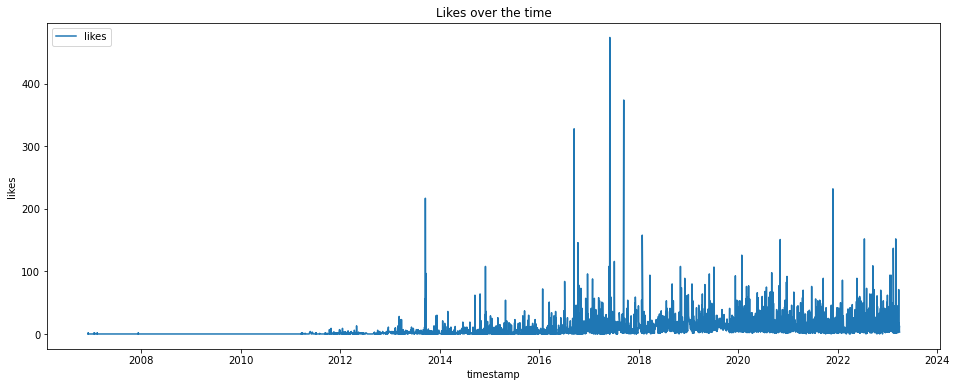

In [75]:
plt.figure(figsize=(16, 6))
plt.plot(time_axis, likes_count)
plt.ylabel('likes')
plt.xlabel('timestamp')
plt.title('Likes over the time')
plt.legend(['likes'], loc='upper left')
plt.show()

In [76]:
# reposts by days
reposts_count = [
    x.items_reposts_count 
    for x in sdf_posts.sort('items_date').select('items_reposts_count').collect()
]

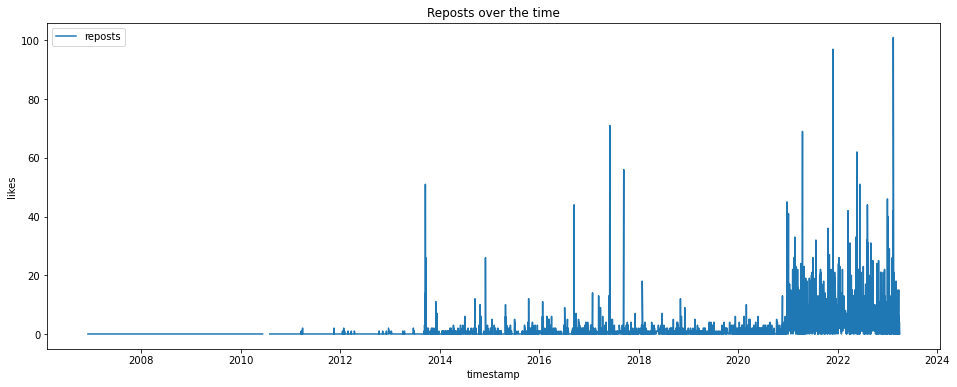

In [77]:
plt.figure(figsize=(16, 6))
plt.plot(time_axis, reposts_count)
plt.ylabel('likes')
plt.xlabel('timestamp')
plt.title('Reposts over the time')
plt.legend(['reposts'], loc='upper left')
plt.show()

In [78]:
# comments by day of week
sdf_posts = sdf_posts.withColumn('items_date_dow', F.dayofweek('items_date'))
sdf_posts.limit(7).toPandas()

items_date                                         items_text  \
0 2023-02-01 09:30:08  –ò–Ω—Ç–µ—Ä–µ—Å–Ω–æ –ø–æ—Ä–∞–±–æ—Ç–∞—Ç—å –Ω–∞–¥ —Ä–µ–∞–ª—å–Ω—ã–º –ø—Ä–æ–µ–∫—Ç–æ–º –¥–ª—è...   
1 2007-07-21 19:58:28  –î—Ä—É–∑—å—è!\n–û–±—ä–µ–¥–∏–Ω–∏–º—Å—è –Ω–∞ –±–ª–∞–≥–æ —Å–æ-—Å—Ç—É–¥–µ–Ω—Ç–∞ :)\n...   
2 2019-01-15 07:20:00  #GSOMstudents\n\n–†–µ–±—è—Ç–∞ –∏–∑ [club89500784|GSOM ...   
3 2014-05-18 20:07:12                                                      
4 2022-10-14 12:18:12  –í –í–®–ú –°–ü–±–ì–£ —Ä–∞–±–æ—Ç–∞—é—Ç —è—Ä–∫–∏–µ, —Ä–∞–∑–Ω–æ—Å—Ç–æ—Ä–æ–Ω–Ω–∏–µ, —Ç–∞...   
5 2015-10-08 13:25:06  –ù–∞—à–∏ –º–∞–≥–∏—Å—Ç—Ä—ã –æ—Ä–≥–∞–Ω–∏–∑—É—é—Ç –≤—Å—Ç—Ä–µ—á—É —Å –°–ï–û CarPric...   
6 2015-04-22 10:39:33                                                      

   items_comments_count  items_likes_count  items_reposts_count  \
0                     0                 14                   11   
1                     0                  0                    0   
2                     0                 17                    0   
3                     0                  1                    0   
4                     4                 61                   24   
5                     0                  6                    0   
6                     0                  2                    0   

   items_date_dow  
0               4  
1               7  
2               3  
3               1  
4               6  
5               5  
6               4

In [79]:
comments_dow = sdf_posts.groupBy('items_date_dow').sum().collect()

In [80]:
comments_dow

[Row(items_date_dow=1, sum(items_comments_count)=61, sum(items_likes_count)=1833, sum(items_reposts_count)=188, sum(items_date_dow)=403),
 Row(items_date_dow=6, sum(items_comments_count)=246, sum(items_likes_count)=7687, sum(items_reposts_count)=1467, sum(items_date_dow)=5856),
 Row(items_date_dow=3, sum(items_comments_count)=246, sum(items_likes_count)=8151, sum(items_reposts_count)=1459, sum(items_date_dow)=3360),
 Row(items_date_dow=5, sum(items_comments_count)=260, sum(items_likes_count)=9113, sum(items_reposts_count)=1955, sum(items_date_dow)=5455),
 Row(items_date_dow=4, sum(items_comments_count)=273, sum(items_likes_count)=7918, sum(items_reposts_count)=1508, sum(items_date_dow)=4244),
 Row(items_date_dow=7, sum(items_comments_count)=148, sum(items_likes_count)=3380, sum(items_reposts_count)=435, sum(items_date_dow)=3381),
 Row(items_date_dow=2, sum(items_comments_count)=276, sum(items_likes_count)=9666, sum(items_reposts_count)=1612, sum(items_date_dow)=2152)]

In [81]:
comments_dow = [(x['items_date_dow'], x['sum(items_comments_count)']) for x in comments_dow]
comments_dow

[(1, 61), (6, 246), (3, 246), (5, 260), (4, 273), (7, 148), (2, 276)]

In [82]:
dow = [x[0] for x in comments_dow]
comments = [x[1] for x in comments_dow]

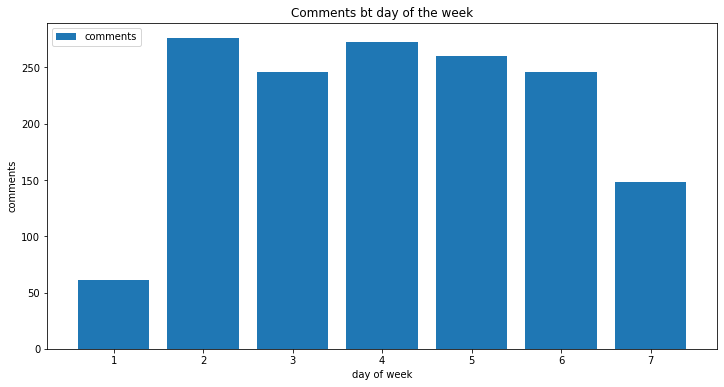

In [83]:
plt.figure(figsize=(12, 6))
plt.bar(dow, comments)
plt.ylabel('comments')
plt.xlabel('day of week')
plt.title('Comments bt day of the week')
plt.legend(['comments'], loc='upper left')
plt.show()